In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colormaps as cm
from matplotlib.colors import LinearSegmentedColormap
import math
import cv2
import torch

In [2]:
n=1500
lambdad = 532e-9
gap = 400e-9
fh=2.4e-3 # 增大这个会使得H相位趋于平坦，反之趋于陡峭
fv=2.38e-3
theta = np.pi*0/18
padnum = 50

def phi(x,y):
    return -np.pi*(fv+fh)/2/lambdad/fh/fv*(x**2+y**2)
def delta(x,y):
    return -np.pi*(fv-fh)/2/lambdad/fh/fv*(x**2+y**2)

x=np.linspace(-n/2*gap,n/2*gap,n)
y=np.linspace(-n/2*gap,n/2*gap,n)
X,Y=np.meshgrid(x,y)

Eout = 0.5*np.exp(1j*phi(X,Y))*(np.cos(theta)*np.exp(1j*delta(X,Y))+np.sin(theta)*np.exp(-1j*delta(X,Y)))
Eout = np.pad(Eout,[(padnum,padnum),(padnum,padnum)],'constant')

In [3]:
# metalens mask
def metalens_fliter(xx,yy):
    dis = np.sqrt(xx**2+yy**2) # 算出中心距离
    mask = np.zeros([n,n])
    for i in range(n):
        for j in range(n):
            if(dis[i][j] < (n/2*gap)):
                mask[i][j] = 1
    return mask

# 角谱法
def AS_Propagation(Uin,z,lambdad,L):
    
    nx = Uin.shape[0]
    ny = Uin.shape[1]
    x = np.linspace(-nx//2,nx//2-1,nx)
    y = np.linspace(-ny//2,ny//2-1,ny)
    X,Y=np.meshgrid(x,y)
    fx = X/L
    fy = Y/L
    k = 2*np.pi/lambdad
    q = fx**2 + fy**2
    H = np.exp(1.0j*k*z*np.sqrt(1-(lambdad**2)*q))
    O = np.fft.fftshift(np.fft.fft2(np.fft.fftshift(Uin)))
    U = np.fft.fftshift(np.fft.ifft2(np.fft.fftshift(H*O)))
    
    return U

mask = metalens_fliter(X,Y)
mask = np.pad(mask,[(padnum,padnum),(padnum,padnum)],'constant',constant_values=0)

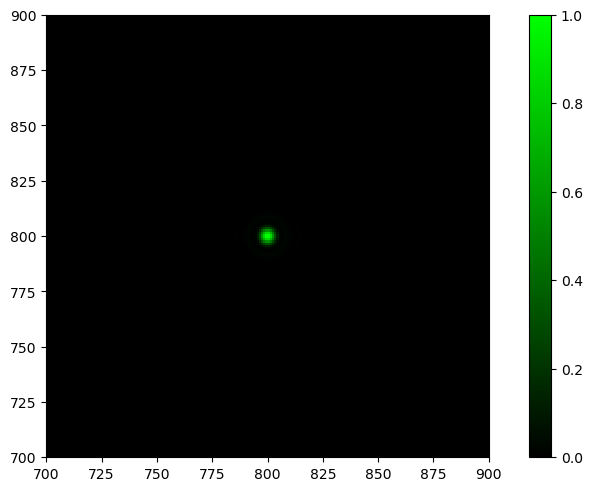

2.4000000000000004


In [5]:
color = [(0,0,0),(0,1,0)]
gb = LinearSegmentedColormap.from_list('gb', color, N=256)
z =2.382e-3
Eout = Eout*mask
#Eout = Eout + 0.5
U = AS_Propagation(Eout,z,lambdad,Eout.shape[0]*gap)
Inorm = np.abs(U*np.conj(U))/np.max(np.abs(U*np.conj(U)))
fig, axs = plt.subplots(1, 1,constrained_layout=True, squeeze=False)
for [ax, cmap] in zip(axs.flat, [gb]):
    psm = ax.pcolormesh(Inorm, cmap=cmap, rasterized=True)
    ax.set_ylim(700,900)
    ax.set_xlim(700,900)
    ax.set_aspect(1)
    fig.colorbar(psm, ax=ax)
plt.show()

def FWHM(spot):
    spot_max = np.max(spot) 
    for i in range(spot.shape[0]):
        if spot[spot.shape[1]//2-1][i] < spot_max/2 and spot[spot.shape[1]//2-1][i+1] >= spot_max/2:
            return (spot.shape[0]//2-i-1)*2
            
fwhm = FWHM(Inorm)*0.4
print(fwhm)

In [18]:
# diffraction
field = np.zeros([200,3001],dtype = complex)
diff = np.linspace(0,3000e-6,3001)
theta = np.pi*90/180
Eout = 0.5*np.exp(1j*phi(X,Y))*(np.cos(theta)*np.exp(1j*delta(X,Y))+np.sin(theta)*np.exp(-1j*delta(X,Y)))
Eout = np.pad(Eout,[(padnum,padnum),(padnum,padnum)],'constant')
Eout = Eout*mask
for i in range(3001):
    z = diff[i]
    U = AS_Propagation(Eout,z,lambdad,Eout.shape[0]*gap)
    field[:,i] = U[700:900,800]

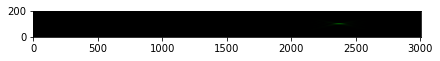

In [19]:
color = [(0,0,0),(0,1,0)]
gb = LinearSegmentedColormap.from_list('gb', color, N=256)
fig, axs = plt.subplots(1, 1,constrained_layout=True, squeeze=False)
for [ax, cmap] in zip(axs.flat, [gb]):
    psm = ax.pcolormesh(np.abs(field*np.conj(field)), cmap=cmap, rasterized=True)
    ax.set_aspect(1)
    #fig.colorbar(psm, ax=ax,aspect =1,location = 'bottom')
plt.show()

focal length is 2362.0um


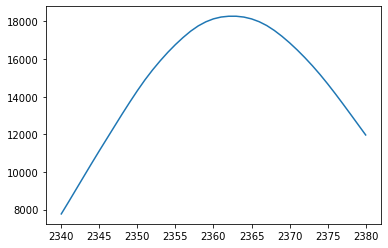

In [17]:
# 计算超透镜衍射焦距
fh=2400e-6 # 增大这个会使得H相位趋于平坦，反之趋于陡峭
fv=2380e-6
theta = theta = np.pi* 90/180
Eout = 0.5*np.exp(1j*phi(X,Y))*(np.cos(theta)*np.exp(1j*delta(X,Y))+np.sin(theta)*np.exp(-1j*delta(X,Y)))
Eout = np.pad(Eout,[(padnum,padnum),(padnum,padnum)],'constant')
zd = np.linspace(fv-40e-6,fh-20e-6,41)
Umax =np.zeros(41)
for i in range(41):
    z = zd[i]
    U = AS_Propagation(Eout,z,lambdad,Eout.shape[0]*gap)
    Umax[i] = np.max(np.abs(U*np.conj(U)))
plt.plot(zd*1e6,Umax)
max_U = 0
for a in range(41):
    if Umax[a]>max_U:
        max_U = Umax[a]
        maxindex = a
print("focal length is "+str(zd[maxindex]*1e6)+"um")

In [ ]:
fh=2400e-6 # 增大这个会使得H相位趋于平坦，反之趋于陡峭
fv=2380e-6
zd = np.linspace(fv-100e-6,fh+100e-6,50)
td = np.linspace(0,180,13)
Umax =np.zeros(50)
focal_length = np.zeros(13)
for j in range(13):
    theta = np.pi*td[j]/180
    Eout = 0.5*np.exp(1j*phi(X,Y))*(np.cos(theta)*np.exp(1j*delta(X,Y))+np.sin(theta)*np.exp(-1j*delta(X,Y)))
    Eout = np.pad(Eout,[(padnum,padnum),(padnum,padnum)],'constant')
    Eout = Eout*mask
    for i in range(50):
        z = zd[i]
        U = AS_Propagation(Eout,z,lambdad,Eout.shape[0]*gap)
        Umax[i] = np.max(np.abs(U))
    #plt.plot(zd,Umax)
    max_U = 0
    for a in range(50):
            if Umax[a]>max_U:
                max_U = Umax[a]
                maxindex = a
    focal_length[j] = zd[maxindex]*1e6
plt.plot(td,focal_length)
print(np.max(focal_length)-np.min(focal_length))

In [ ]:
fh=2400e-6 # 增大这个会使得H相位趋于平坦，反之趋于陡峭
fv=2380e-6
zd = np.linspace(fv-100e-6,fh+100e-6,50)
td = np.linspace(0,180,13)
Umax =np.zeros(50)
focal_length = np.zeros(13)
for j in range(13):
    theta = np.pi*td[j]/180
    Eout = 0.5*np.exp(1j*phi(X,Y))*(np.cos(theta)*np.exp(1j*delta(X,Y))+np.sin(theta)*np.exp(-1j*delta(X,Y)))
    Eout = np.pad(Eout,[(padnum,padnum),(padnum,padnum)],'constant')
    Eout = Eout*mask
    for i in range(50):
        z = zd[i]
        U = AS_Propagation(Eout,z,lambdad,Eout.shape[0]*gap)
        Umax[i] = np.max(np.abs(U))
    #plt.plot(zd,Umax)
    max_U = 0
    for a in range(50):
            if Umax[a]>max_U:
                max_U = Umax[a]
                maxindex = a
    focal_length[j] = zd[maxindex]*1e6
plt.plot(td,focal_length)
print(np.max(focal_length)-np.min(focal_length))

In [ ]:
# 瑞利索墨菲衍射
z=3.2e-3
xpad = np.linspace(-Eout.shape[0]/2*gap,Eout.shape[0]/2*gap,Eout.shape[0])
Xpad,Ypad=np.meshgrid(xpad,xpad)
                                                   
r = np.sqrt(Xpad**2+Ypad**2+z**2)
k = 2*np.pi/lambdad
h = 1/(2*np.pi)*(z/r)*(1-1j*k*r)/(r**2)*np.exp(1j*k*r)
h = h*mask
H = np.fft.fftshift(np.fft.fft2(np.fft.fftshift(h)))
O = np.fft.fftshift(np.fft.fft2(np.fft.fftshift(Eout)))
U = np.fft.fftshift(np.fft.ifft2(np.fft.fftshift(H*O)))
jet = cm.get_cmap('jet')
fig, axs = plt.subplots(1, 1,constrained_layout=True, squeeze=False)
for [ax, cmap] in zip(axs.flat, [jet]):
    psm = ax.pcolormesh(np.abs(U), cmap=cmap, rasterized=True)
    ax.set_aspect(1)
    fig.colorbar(psm, ax=ax)
plt.show()

In [ ]:
jet = cm.get_cmap('jet', 256)
fig, axs = plt.subplots(1, 1,constrained_layout=True, squeeze=False,figsize=(8,8))
for [ax, cmap] in zip(axs.flat, [jet]):
    psm = ax.pcolormesh(np.abs(RSD_XZ), cmap=cmap, rasterized=True)
    ax.set_aspect(1/4)
    fig.colorbar(psm, ax=ax)
plt.show()